In [2]:
import os
from src.utils import data_load
import pandas as pd
from src.s3_utils import pandas_from_csv_s3
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from utils import get_survey_question, na_rate
import torch
import matplotlib.dates as mdates
import pingouin as pg

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-yymzsoa5 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# wave = 7
# bucket = 'fouryouandme-study-data'
# dfs = {}
# key = f'bump/redcap/wave_{wave}/pitting_edema.csv.gz'
# df_pitting_edema_cohort_2_only = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# dfs['pitting_edema'] = df_pitting_edema_cohort_2_only
df_survey = data_load(data_keys={"surveys"}, wave=7)['surveys']
data = data_load(data_keys={'pitting_edema'}, wave=7)['pitting_edema']
df_birth = data_load(data_keys={"birth"}, wave=5)['birth']

In [4]:
df_sleep = data_load(data_keys={"oura_sleep"}, wave=5)['oura_sleep']


In [5]:
df_sleep.columns

Index(['id', 'user_id', 'identity_id', 'created_at', 'updated_at',
       'retrieved_at', 'subsource', 'event_date', 'awake', 'bedtime_end',
       'bedtime_end_delta', 'bedtime_start', 'bedtime_start_delta',
       'breath_average', 'deep', 'duration', 'efficiency', 'hr_5min',
       'hr_average', 'hr_lowest', 'hypnogram_5min', 'is_longest', 'light',
       'midpoint_at_delta', 'midpoint_time', 'onset_latency', 'period_id',
       'rem', 'restless', 'rmssd', 'rmssd_5min', 'score', 'score_alignment',
       'score_deep', 'score_disturbances', 'score_efficiency', 'score_latency',
       'score_rem', 'score_total', 'temperature_delta',
       'temperature_deviation', 'temperature_trend_deviation', 'timezone',
       'total', 'date'],
      dtype='object')

In [6]:
df_birth[df_birth['user_id'] == 79]

,record_id,redcap_event_name_x,birth_number,birth_date,birth_scheduled,birth_scheduled_unsure,birth_gestage,birth_mode,induction_yn,induction_reason,...,date,redcap_event_name_y,participant_id,sema4_id,evidation_id,evidation_id_prior1,evidation_id_prior2,evidation_id_c,study_ids_complete,user_id
26,49,postnatal_checkin_arm_1,1.0,2022-03-31,2.0,NaN,"38 weeks, 6 days",1.0,NaN,NaN,...,2022-03-31,enrollment__partic_arm_1,49,EVI-QXHYUKIM,79.0,NaN,NaN,NaN,2,79.0


In [7]:

all_data = None

for u in data['user_id'].unique():
    edema_csv_path = f'/mnt/results/edema_coarse_label/user_{u}_edema_coarse_label.csv'
    if not os.path.exists(edema_csv_path):
        #print("Empty Edema")
        continue
    edema_df = pd.read_csv(edema_csv_path).groupby("date", as_index = False).first()[['date', 'answer_text']]
    pitting_edema_df = data[data['user_id'] == u][['date', 'pitting_edema']]
    combined = pd.merge(edema_df, pitting_edema_df, how='left')
    # combine daily edema and pitting edema, only keeping those with pitting edema available
    combined_right = pd.merge(edema_df, pitting_edema_df, how='right')
    combined_right = combined_right.dropna()
    def add_username(date, username):
        return str(date) + '_' + username

    if len(combined_right):
        # Apply the custom function to modify the column
        combined_right['date_username'] = combined_right.apply(lambda row: add_username(row['date'], str(u)), axis=1)
        combined_right['user_id'] = str(u)
        # combined_right = combined_right.drop('date', axis=1)
        # print(combined_right)
        if all_data is None:
            all_data = combined_right
        else:
            all_data = all_data.append(combined_right, ignore_index=True)
    # if combined['pitting_edema'].count():
    # # Reshape the DataFrame using melt()
    #     melted_df = combined.melt(id_vars='date', var_name='y_label', value_name='y_value')

    #     # Plot the values using sns.lineplot()
    #     ax = sns.stripplot(data=melted_df, x='date', y='y_value', hue='y_label')
    #     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    #     ax.figure.savefig((os.path.join('/', 'mnt', 'results', 'pitting_edema', f'{u}.png')))       
        
    #     ax.figure.clf()
melted_df = all_data.drop('date', axis=1).drop('user_id', axis=1).melt(id_vars='date_username', var_name='y_label', value_name='y_value')
icc = pg.intraclass_corr(data=melted_df, targets='date_username', raters='y_label', ratings='y_value')

icc.set_index('Type')
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,-0.353934,0.477177,796,797,1.000000e+00,"[-0.41, -0.29]"
1,ICC2,Single random raters,0.086825,1.662539,796,796,4.988673e-13,"[-0.06, 0.24]"
2,ICC3,Single fixed raters,0.248837,1.662539,796,796,4.988673e-13,"[0.18, 0.31]"
3,ICC1k,Average raters absolute,-1.095657,0.477177,796,797,1.000000e+00,"[-1.41, -0.82]"
4,ICC2k,Average random raters,0.159777,1.662539,796,796,4.988673e-13,"[-0.12, 0.39]"
5,ICC3k,Average fixed raters,0.398510,1.662539,796,796,4.988673e-13,"[0.31, 0.48]"


In [8]:
all_data

,date,answer_text,pitting_edema,date_username,user_id
0,2021-04-29,1.0,0.0,2021-04-29_28,28
1,2021-05-27,1.0,0.0,2021-05-27_28,28
2,2021-07-22,1.0,0.0,2021-07-22_28,28
3,2021-04-06,1.0,0.0,2021-04-06_29,29
4,2021-06-03,1.0,0.0,2021-06-03_29,29
...,...,...,...,...,...
792,2023-01-10,1.0,0.0,2023-01-10_2551,2551
793,2023-02-07,1.0,0.0,2023-02-07_2551,2551
794,2022-11-17,1.0,0.0,2022-11-17_2637,2637
795,2023-01-19,1.0,0.0,2023-01-19_2637,2637


[0. 1. 2. 5. 3. 4. 6.]


<AxesSubplot:xlabel='answer_text', ylabel='pitting_edema'>

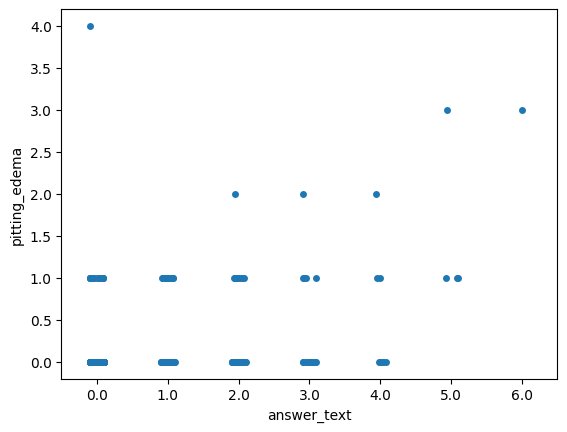

In [9]:
all_data.answer_text = all_data.answer_text - 1
print(all_data.answer_text.unique())
sns.stripplot(data=all_data, x='answer_text', y='pitting_edema')

In [10]:
all_data.answer_text.unique

<bound method Series.unique of 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
792    0.0
793    0.0
794    0.0
795    0.0
796    0.0
Name: answer_text, Length: 797, dtype: float64>

In [11]:

severe_daily_no_pitting = (all_data['answer_text'] >=2.0) & (all_data['pitting_edema'] == 0.0)
no_daily_severe_pitting = (all_data['answer_text'] == 0.0) & (all_data['pitting_edema'] > 0.0)

unreliable_users = all_data[(severe_daily_no_pitting | no_daily_severe_pitting)].user_id.unique()

reliable_data = all_data[~all_data['user_id'].isin(unreliable_users)]

<AxesSubplot:xlabel='answer_text', ylabel='pitting_edema'>

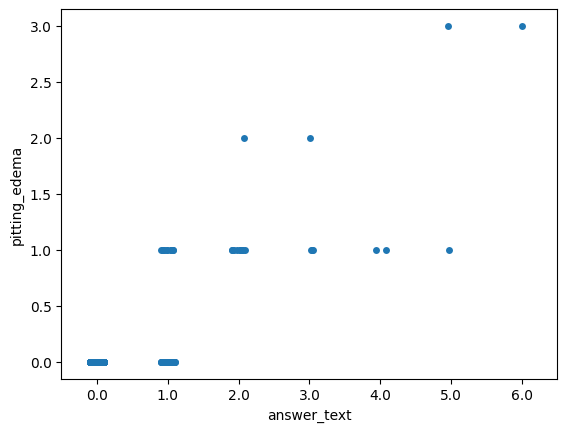

In [12]:
sns.stripplot(data=reliable_data, x='answer_text', y='pitting_edema')

In [25]:
melted_df = reliable_data.drop('date', axis=1).drop('user_id', axis=1).melt(id_vars='date_username', var_name='y_label', value_name='y_value')
icc = pg.intraclass_corr(data=melted_df, targets='date_username', raters='y_label', ratings='y_value')

icc.set_index('Type')
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.577363,3.732189,609,610,5.766981e-56,"[0.52, 0.63]"
1,ICC2,Single random raters,0.585792,4.129887,609,609,7.024325e-64,"[0.49, 0.66]"
2,ICC3,Single fixed raters,0.610128,4.129887,609,609,7.024325e-64,"[0.56, 0.66]"
3,ICC1k,Average raters absolute,0.732061,3.732189,609,610,5.766981e-56,"[0.69, 0.77]"
4,ICC2k,Average random raters,0.738800,4.129887,609,609,7.024325e-64,"[0.66, 0.79]"
5,ICC3k,Average fixed raters,0.757863,4.129887,609,609,7.024325e-64,"[0.72, 0.79]"


In [30]:
print(reliable_data.user_id.unique())

['28' '29' '30' '35' '37' '38' '39' '42' '44' '45' '47' '53' '54' '64'
 '65' '66' '67' '68' '74' '75' '79' '80' '94' '95' '1431' '1393' '99'
 '114' '118' '119' '2093' '122' '124' '127' '135' '137' '155' '1014' '156'
 '158' '1373' '168' '1000' '173' '174' '185' '186' '1001' '190' '192'
 '193' '199' '200' '212' '1021' '972' '1724' '1004' '1429' '234' '975'
 '280' '289' '290' '291' '292' '404' '405' '407' '408' '409' '410' '977'
 '1047' '428' '581' '594' '595' '600' '603' '615' '1658' '1045' '983'
 '966' '969' '985' '987' '989' '991' '992' '1005' '1455' '1038' '1044'
 '2117' '2225' '2226' '2120' '1363' '1366' '1367' '1378' '1719' '2151'
 '1383' '1386' '1387' '1721' '1425' '1426' '1427' '1432' '1436' '1439'
 '1440' '1443' '1697' '1452' '1700' '1703' '1706' '1707' '1708' '1709'
 '1710' '1712' '1715' '1716' '1728' '1731' '1743' '1745' '1749' '1750'
 '2187' '2091' '2197' '1976' '1988' '1989' '1994' '1995' '1996' '1997'
 '1999' '2000' '2001' '2004' '2014' '2016' '2018' '2019' '2038' '2032'
 '2

In [29]:
df_survey.loc[df_survey['title'] =='Fatigue survey']

,id,user_id,survey_id,title,event_date,from,to,created_at,updated_at,question_id,question_text,answer_text,record_id,date
449065,2410634,2486,7,Fatigue survey,2022-11-02 00:00:00,2022-11-02 01:00:00,2022-11-03 00:00:00,2022-11-02 00:29:43.81752,2022-11-02 07:11:00.731747,148,"During the past week, did you experience any f...",No,direct_298,2022-11-02
449066,2731334,2492,7,Fatigue survey,2023-01-03 00:00:00,2023-01-03 01:00:00,2023-01-04 00:00:00,2023-01-02 23:58:55.375587,2023-01-03 15:04:45.158857,148,"During the past week, did you experience any f...",No,direct_286,2023-01-03
449067,2145988,2498,7,Fatigue survey,2022-09-22 00:00:00,2022-09-22 00:00:00,2022-09-23 00:00:00,2022-09-22 00:39:56.495817,2022-09-22 15:34:43.844404,148,"During the past week, did you experience any f...",No,direct_256,2022-09-22
449068,2528159,2502,7,Fatigue survey,2022-11-24 00:00:00,2022-11-24 01:00:00,2022-11-25 00:00:00,2022-11-23 23:40:23.424707,2022-11-24 21:16:21.140998,148,"During the past week, did you experience any f...",No,direct_281,2022-11-24
449069,2139668,2492,7,Fatigue survey,2022-09-21 00:00:00,2022-09-21 00:00:00,2022-09-22 00:00:00,2022-09-21 00:33:12.035996,2022-09-21 17:04:46.516896,148,"During the past week, did you experience any f...",No,direct_286,2022-09-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529609,2092509,2126,7,Fatigue survey,2022-09-13 00:00:00,2022-09-13 01:00:00,2022-09-14 00:00:00,2022-09-13 00:36:33.902193,2022-09-13 20:02:21.018958,158,"During the past week, I have found that:\r\n\r...",Always,sema4_359,2022-09-13
529610,1707318,2126,7,Fatigue survey,2022-07-05 00:00:00,2022-07-05 01:00:00,2022-07-06 00:00:00,2022-07-05 00:30:20.417923,2022-07-05 20:06:46.435022,158,"During the past week, I have found that:\r\n\r...",Always,sema4_359,2022-07-05
529611,1743413,2126,7,Fatigue survey,2022-07-12 00:00:00,2022-07-12 01:00:00,2022-07-13 00:00:00,2022-07-12 00:28:45.39387,2022-07-12 18:36:37.466102,158,"During the past week, I have found that:\r\n\r...",Always,sema4_359,2022-07-12
529612,2938398,2126,7,Fatigue survey,2023-02-14 00:00:00,2023-02-14 01:00:00,2023-02-15 00:00:00,2023-02-13 23:48:10.520462,2023-02-14 22:55:33.291041,158,"During the past week, I have found that:\r\n\r...",Always,sema4_359,2023-02-14


In [28]:
df_survey['title'].unique()

array(['Daily survey', 'Global survey', 'Engagement survey',
       'Pilot survey', 'Baseline survey', 'COVID-19 Baseline survey',
       'Healthcare Utilization survey', 'PUQE',
       'Pain Interference survey', 'Sleep Related Impairment survey',
       'Emotional Support survey', 'COVID Infection survey',
       'Fatigue survey', 'Personality survey',
       'Severe Symptom and Complication survey'], dtype=object)

In [13]:
data[data['user_id'] == 79]

,user_id,record_id,redcap_event_name,date,edema_yes,edema_where___1,edema_where___2,edema_where___3,edema_other,pitting_edema,pitting_edema_cohort_2_only_complete,pitting_edema_complete
135,79,sema4_49,ci_2_arm_1,2021-06-03,NaN,0,0,0,NaN,NaN,0.0,NaN
136,79,sema4_49,ci_4_arm_1,2021-07-01,NaN,0,0,0,NaN,NaN,0.0,NaN
137,79,sema4_49,ci_6_arm_1,2021-07-29,NaN,0,0,0,NaN,NaN,0.0,NaN
138,79,sema4_49,ci_8_arm_1,2021-08-26,0.0,0,0,0,NaN,0.0,2.0,NaN
139,79,sema4_49,ci_10_arm_1,2021-09-23,0.0,0,0,0,NaN,0.0,2.0,NaN
140,79,sema4_49,ci_12_arm_1,2021-10-21,NaN,0,0,0,NaN,0.0,2.0,NaN
141,79,sema4_49,ci_14_arm_1,2021-11-18,0.0,0,0,0,NaN,0.0,2.0,NaN
142,79,sema4_49,ci_16_arm_1,2021-12-16,0.0,0,0,0,NaN,0.0,2.0,NaN
143,79,sema4_49,ci_18_arm_1,2022-01-20,NaN,0,0,0,NaN,NaN,0.0,NaN
144,79,sema4_49,ci_20_arm_1,2022-02-15,0.0,0,0,0,NaN,NaN,2.0,NaN


In [14]:
data[data['redcap_event_name'] == 'ci_16_arm_1']

,user_id,record_id,redcap_event_name,date,edema_yes,edema_where___1,edema_where___2,edema_where___3,edema_other,pitting_edema,pitting_edema_cohort_2_only_complete,pitting_edema_complete
142,79,sema4_49,ci_16_arm_1,2021-12-16,0.0,0,0,0,NaN,0.0,2.0,NaN
174,84,sema4_54,ci_16_arm_1,2022-01-07,1.0,0,0,0,NaN,0.0,2.0,NaN
223,94,sema4_64,ci_16_arm_1,2022-01-10,1.0,1,0,0,NaN,0.0,2.0,NaN
240,96,sema4_66,ci_16_arm_1,2022-03-09,0.0,0,0,0,NaN,NaN,2.0,NaN
241,455,sema4_66,ci_16_arm_1,2022-03-09,0.0,0,0,0,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2867,2654,sema4_799,ci_16_arm_1,2023-01-10,0.0,0,0,0,NaN,0.0,2.0,NaN
2902,2096,sema4_806,ci_16_arm_1,2022-12-21,0.0,0,0,0,NaN,0.0,2.0,NaN
2903,2223,sema4_806,ci_16_arm_1,2022-12-21,0.0,0,0,0,NaN,0.0,2.0,NaN
2922,2098,sema4_831,ci_16_arm_1,2022-12-29,0.0,0,0,0,NaN,0.0,2.0,NaN


In [15]:
data.pitting_edema.unique()


array([nan,  0.,  3.,  4.,  1.,  2.])

In [16]:
data.edema_yes.value_counts()

0.0    1822
1.0     627
Name: edema_yes, dtype: int64

In [17]:
data.pitting_edema.value_counts()

0.0    1688
1.0     112
2.0       8
3.0       5
4.0       3
Name: pitting_edema, dtype: int64

In [18]:
data[data['edema_yes'] == 1.0].pitting_edema.value_counts()

0.0    478
1.0    110
2.0      7
3.0      4
4.0      3
Name: pitting_edema, dtype: int64

In [19]:
data[data['edema_yes'] == 0.0].pitting_edema.value_counts()

0.0    1204
3.0       1
1.0       1
Name: pitting_edema, dtype: int64

In [20]:
data.redcap_event_name.value_counts()

ci_2_arm_1     592
ci_4_arm_1     552
ci_6_arm_1     500
ci_8_arm_1     457
ci_10_arm_1    361
ci_12_arm_1    217
ci_14_arm_1    133
ci_2_arm_2     125
ci_4_arm_2     121
ci_16_arm_1    114
ci_6_arm_2     106
ci_8_arm_2     102
ci_18_arm_1     98
ci_10_arm_2     79
ci_20_arm_1     76
ci_22_arm_1     44
ci_24_arm_1     27
ci_12_arm_2     25
ci_26_arm_1     13
ci_28_arm_1      7
ci_14_arm_2      2
Name: redcap_event_name, dtype: int64

In [21]:
data[data['pitting_edema_cohort_2_only_complete'] == 2.0].redcap_event_name.value_counts()

ci_8_arm_1     277
ci_4_arm_1     276
ci_6_arm_1     273
ci_2_arm_1     268
ci_10_arm_1    224
ci_12_arm_1    145
ci_14_arm_1    114
ci_16_arm_1    105
ci_18_arm_1     86
ci_20_arm_1     71
ci_22_arm_1     42
ci_24_arm_1     25
ci_26_arm_1     13
ci_28_arm_1      7
Name: redcap_event_name, dtype: int64

{84: 2, 1400: 4, 1745: 4, 2174: 3, 1453: 1, 1374: 2, 2126: 3, 159: 4, 1717: 4, 1696: 4, 604: 4, 1714: 4, 200: 3, 39: 1, 1989: 4, 407: 4, 2267: 4, 992: 4, 1658: 4, 47: 4, 2038: 3, 2061: 3, 2151: 3, 2102: 2, 2066: 4, 1038: 2, 74: 1, 28: 4, 594: 1, 2018: 1, 622: 2, 989: 3, 1743: 2, 2031: 3, 1378: 4, 185: 4, 1996: 3, 2134: 4, 186: 4, 1387: 4, 174: 4, 1440: 1, 2062: 2, 1724: 4, 980: 4, 2001: 4, 66: 1, 1744: 3, 234: 2, 1393: 1, 1032: 4, 1403: 3, 290: 4, 55: 3, 1436: 1, 291: 1, 983: 2, 122: 1, 289: 4, 1731: 3, 2109: 4, 1709: 3, 1708: 4, 1747: 4, 53: 4, 1425: 3, 969: 4, 64: 4, 987: 2, 581: 4, 1993: 1, 2084: 1, 1373: 2, 38: 3, 280: 1, 1426: 4, 1695: 3, 2159: 4, 2120: 2, 190: 3, 1702: 1, 137: 2, 1037: 4, 404: 4, 279: 1, 29: 2, 429: 2, 118: 4, 2142: 3, 2176: 2, 2056: 4, 2080: 4, 1429: 4, 1366: 3, 1988: 1, 2065: 3, 1712: 1, 1432: 1, 603: 2, 1976: 4, 2019: 1, 977: 4, 2113: 3, 991: 2, 1728: 2, 615: 4, 1997: 1, 1427: 2, 1367: 1, 1000: 2, 158: 1, 192: 3, 168: 4, 410: 1, 428: 2, 135: 2, 2015: 3, 2083: 

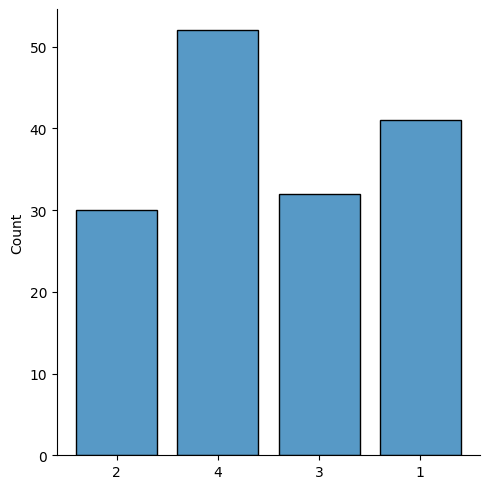

In [22]:
user_dict = {}
for f in os.listdir(os.path.join("/", "mnt", 'dataset', "stress")):

    f_name_lst = f.split('_')
    if 'date' in f_name_lst:
        continue
    
    user_id = int(f_name_lst[1])
    if user_id in user_dict:
        user_dict[user_id] += 1
    else:
        user_dict[user_id] = 1
print(user_dict)
s = []
for i in user_dict:
    s.append(str(user_dict[i]))

sns.displot(s, shrink=.8, bins=['1', '2', '3', '4'])

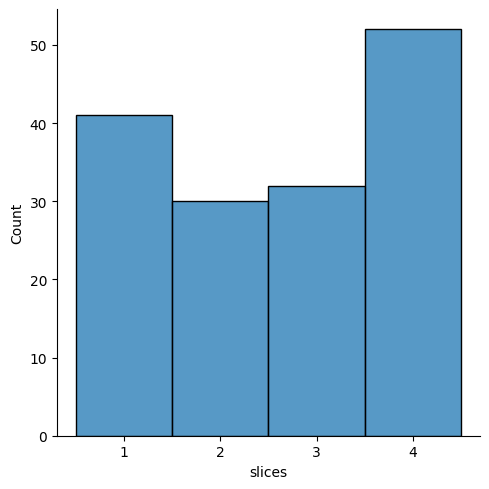

In [23]:
df = pd.DataFrame()
df['slices'] = pd.Categorical(values=s, categories=['1', '2', '3', '4']) ## Set the order for the column as you want
df.sort_values(['slices'], inplace=True) ## Sort the column
sns.displot(data = df, x = 'slices')  ## and plot

In [24]:
len(s)

155